## Geoprozessing mit GeoPandas

**Overlay Funktionen**
Mit den räumlichen Overlay-Funktionen kann man zwei GeoDataFrames (Polygon oder Multipolygon Geometrien) vergleichen und auf Grundlage von räumlichen Bedingungen oder Kombinationen ein neues GeoDataFrame zu erzeugen:
![Overlay!](img/overlay_operations.png "Overlay")

Wichtig: Die Operationen finden nicht auf der Ebene der einzelnen Geometrien statt, sondern Dataframe Ebene, d.h. beide Dataframes behalten ihre Eigenschaften.

Laden wir nun buildings_a2 und landuse_a2 und führen einen intersect aus:

In [1]:
import geopandas as gpd
buildings = gpd.read_file("data/buildings_a2.shp")
landuse = gpd.read_file("data/landuse_a2.shp")
landuse.head()

,fid,osm_id,code,fclass,name,geometry
0,55.0,22988861,7209,commercial,Messe Freiburg,"POLYGON ((872440.227 6109788.806, 872460.342 6..."
1,275.0,30683091,7207,allotments,Gewann Hettlinger,"POLYGON ((872947.599 6109538.179, 873138.166 6..."
2,488.0,37419090,7203,residential,None,"POLYGON ((873263.065 6108010.163, 873260.506 6..."
3,491.0,37427437,7203,residential,Herdern-Süd,"MULTIPOLYGON (((873841.514 6108010.163, 873873..."
4,641.0,51731435,7209,commercial,None,"POLYGON ((871515.527 6108186.373, 871528.175 6..."


Für die `intersection` benötigen wir nun die overlay Funktionen, die mit 3 Argumenten aufgerufen werden:  
- dataframe1
- dataframe2
- how

How kann dabei einer der folgenden Werte annehmen:  

`['intersection',
'union',
'identity',
'symmetric_difference',
'difference']`


In [ ]:
from geopandas.tools import overlay
newdf = overlay(buildings, landuse, how="intersection")
newdf.plot(cmap='tab20b')

In [ ]:
newdf.head()


In [ ]:
872357,873959,6108613,6110035

### Clipping
Das folgende Beispiel zeigt, wie man mit GeoPandas zwei Datensätze basierend auf einem anderen datensatz clippen kann. Beide Datensätze müssen als Geodataframe im selben Bezugssystem vorliegen:

In [ ]:
#benötigte Biliotheken importieren
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
# Shapefile lesen mit gpd.read_file()
world = gpd.read_file("data/countries.shp")
cities = gpd.read_file("data/cities.shp")

#Ein Polygon erstellen aus Koordinaten
polygon = Polygon([(0, 0), (0, 90), (180, 90), (180, 0), (0, 0)])
poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=world.crs)

alles zusammen mit Matplotlib ansehen:

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
world.plot(ax=ax1)
poly_gdf.boundary.plot(ax=ax1, color="red")
cities.plot(ax=ax1, color="purple")
ax1.set_title("World nicht geclippt", fontsize=12)
ax1.set_axis_off()
plt.show()



### Clipping:

In [ ]:
world_clipped = gpd.clip(world, polygon)

# Plot the clipped data
# The plot below shows the results of the clip function applied to the world
# sphinx_gallery_thumbnail_number = 2
fig, ax = plt.subplots(figsize=(12, 8))
world_clipped.plot(ax=ax, color="purple")
world.boundary.plot(ax=ax)
poly_gdf.boundary.plot(ax=ax, color="red")
ax.set_title("World geclipped", fontsize=12)
ax.set_axis_off()
plt.show()

Oder Clipping mit einem unregelmäßigen Polygon:

In [ ]:
south_america = world.loc[(world['continent'] == "South America")]
cities_clipped = gpd.clip(cities, south_america)
#Plot
fig, ax = plt.subplots(figsize=(12, 8))
cities_clipped.plot(ax=ax, color="red")
south_america.boundary.plot(ax=ax, color="green")
ax.set_title("Cities Clipped", fontsize=12)
ax.set_axis_off()
plt.show()

### Mehrere Prozessingschritte kombinieren: Einen optimalen Standort finden  
Anhand von OSM daten soll ein optimaler Wohnstandort in Freiburg ermittelt werden.  
Folgende Bedingungen gelten:
- Maximal 200 Meter von einem Kindergarten entfernt: Layer: pois_p, "fclass" = 'kindergarten'
- Maximal 500 Meter von einer Schule entfernt: Layer: pois_p, "fclass" = 'school'
- Mindestens 250 Meter von einer Straße mit erlaubter Geschwindigkeit >30km/h: Layer roads_l, maxspeed > 30


TYP <class 'shapely.geometry.multipolygon.MultiPolygon'>
                                            geometry
0  POLYGON ((873617.065 6104287.210, 873610.993 6...
1  POLYGON ((872964.284 6105820.503, 872969.486 6...
2  POLYGON ((873832.986 6106867.589, 873848.017 6...
3  POLYGON ((874899.990 6107636.866, 874899.027 6...
4  POLYGON ((874859.260 6107380.146, 874872.357 6...


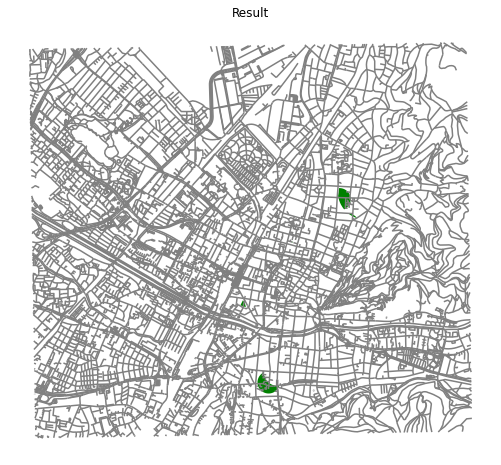

In [62]:
from geopandas.tools import overlay
#Daten laden
pois = gpd.read_file("data/pois_p.shp")
roads = gpd.read_file("data/roads_l.shp")

#Filtern & Puffern
#Ergebnisse sind vom Typ "MULTIPOLYGON"
pois_k = pois.loc[(pois['fclass'] == 'kindergarten')].buffer(200).unary_union
pois_s = pois.loc[(pois['fclass'] == 'school')].buffer(500).unary_union
roads30 = roads.loc[(roads['maxspeed'] > 30)].buffer(250).unary_union
print("TYP", type(roads30))

#Deswegen kommen hier Methoden aus shapely zum Einsatz
intersection = pois_k.intersection(pois_s)
difference = intersection.difference(roads30)

#Das Ergebnis wieder in ein GeoPandas Dataframe überführen
result = gpd.GeoDataFrame({'geometry':difference})
print(result.head())

#Karte erstellen
fig, ax = plt.subplots(figsize=(12, 8))
result.plot(ax=ax, color="green")
#pois.plot(ax=ax, color="purple")
roads.plot(ax=ax, color="grey")
ax.set_title("Result", fontsize=12)
ax.set_axis_off()
plt.show()
